In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, event
import urllib.parse
import time

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns 
sns.set(rc={'figure.figsize':(18,18)})

# Inputs

In [2]:
#SQL
server = 'CSKMA0400\RDB_Data'
db = 'JLDJobPath'
odbc_connection_string = 'DRIVER={SQL Server Native Client 11.0};SERVER='+server+';DATABASE='+db+';Trusted_Connection=yes'

#input table -- NOTE: output tables are automatically named and uploaded -- see output logs at the end
sql_table = "linkedclaims_casuals_2018m04_v2_flat_multi_with_income"

#input variable profile file
varprofile_csvfilename = "D:/DATA/linkedclaims_casuals_2018m04_v2_flat_20140101_with_income_with_edu_variable_profile.csv"

# Set to TRUE if you want to 
# normalise variables counting levels with name starting with 'total_duration_days_'
# by variable 'total_duration_days' -- Note: make sure the variables are selected in the variable profile csv file
do_normalize_total_day_counts = True
drop_normalisation_column = True

# Set to TRUE if you want to 
# sum columns and update accordingly the list of lists below, 
# eg Col_A + Col_B and Col_B + Col_C + Col_D: [[Col_A, Col_B], [Col_B, Col_C, Col_D]]
do_sum_columns = False
columns_to_sum = [['Class_A_Earn0','Class_S_Earn0','Class_Other_Earn0'],
                  ['Class_A_Earn1','Class_S_Earn1','Class_Other_Earn1'],
                  ['Class_A_Earn2','Class_S_Earn2','Class_Other_Earn2'],
                  ['Class_A_Earn3','Class_S_Earn3','Class_Other_Earn3'],
                  ['Class_A_Earn4','Class_S_Earn4','Class_Other_Earn4']
                  ]
drop_original_cols = False # Set this to TRUE if you want to drop the cols summed

# Set to TRUE if you want to 
# divide columns and update accordingly the list of lists below, 
# eg Col_A/Col_B and Col_B/Col_C/Col_D: [[Col_A, Col_B], [Col_B, Col_C, Col_D]]
do_divide_columns = True
columns_to_divide = [['Class_A_Earn0','Class_A_weeks0'], 
                     ['Class_A_Earn1','Class_A_weeks1'],
                     ['Class_A_Earn2','Class_A_weeks2'],
                     ['Class_A_Earn3','Class_A_weeks3'], 
                     ['Class_A_Earn4','Class_A_weeks4']]
drop_nominator = True     # Set to TRUE if you want to drop the nominator cols
drop_denominator = False  # Set to TRUE if you want to drop the denominator cols

# Set to TRUE if you want to apply Dirichelet Prior
do_dirichlet_prior = True
do_clip_to_zero = True

#Control flags for mixture modelling & feature importance estimation
use_bayesian_mixtures = True # if false Gaussian Mixture Models are used
use_full_covariance = True # if false diagonal covariance is used
n_clusters = 7
n_iterations = 3

# Put to False if you dont want to see plots
show_plots = True

# Procedure

Reading data from SQL
Selecting Variables and filling na
Normalising total_day_counts
PCA Scatterplot
Dividing Columns
List of Variables:
['End_weekly_rate_0', 'LM_code_rank_0', 'age', 'duration_days_0', 'sex', 'total_duration_days_nat_code_Irish', 'total_max_LM_code_rank', 'total_max_ada_code_rank', 'total_max_family_flag_rank', 'total_max_marital_status_rank', 'total_max_occupation_rank', 'total_min_LM_code_rank', 'total_min_ada_code_rank', 'total_min_family_flag_rank', 'total_min_marital_status_rank', 'total_min_occupation_rank', 'Class_S_Earn0', 'Class_S_Earn1', 'Class_S_Earn2', 'Class_S_Earn3', 'Class_S_Earn4', 'Class_Other_Earn0', 'Class_Other_Earn1', 'Class_Other_Earn2', 'Class_Other_Earn3', 'Class_Other_Earn4', 'Class_A_weeks0', 'Class_A_weeks1', 'Class_A_weeks2', 'Class_A_weeks3', 'Class_A_weeks4', 'Class_A_Earn0/Class_A_weeks0', 'Class_A_Earn1/Class_A_weeks1', 'Class_A_Earn2/Class_A_weeks2', 'Class_A_Earn3/Class_A_weeks3', 'Class_A_Earn4/Class_A_weeks4']
Total Number of varia

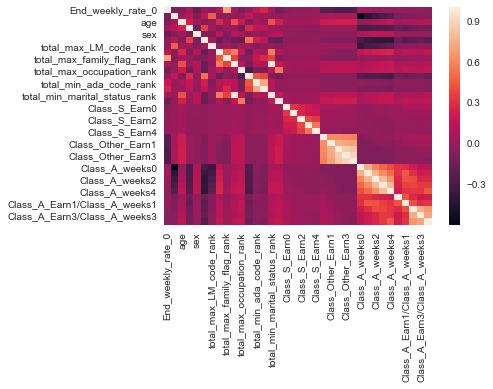

PCA Scatterplot


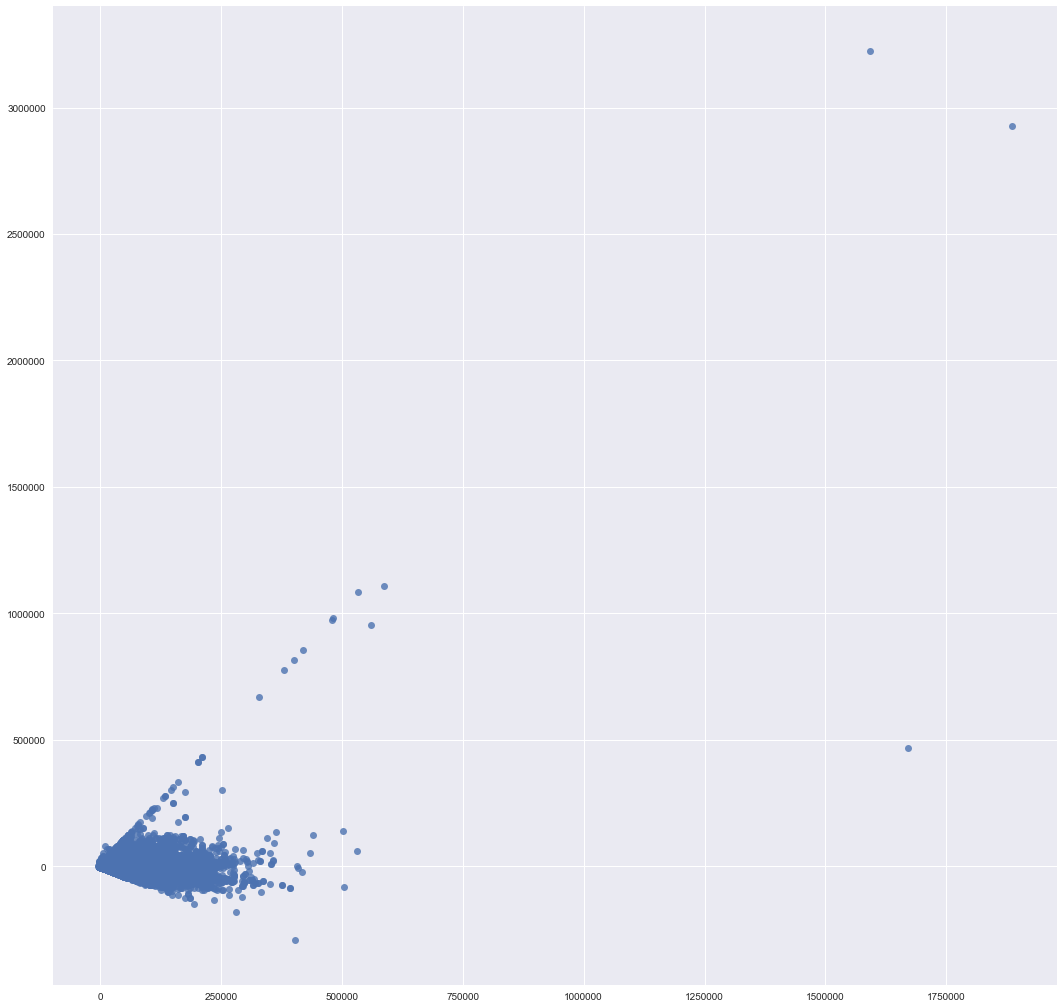

Applying Dirichlet Prior
Correlation Matrix


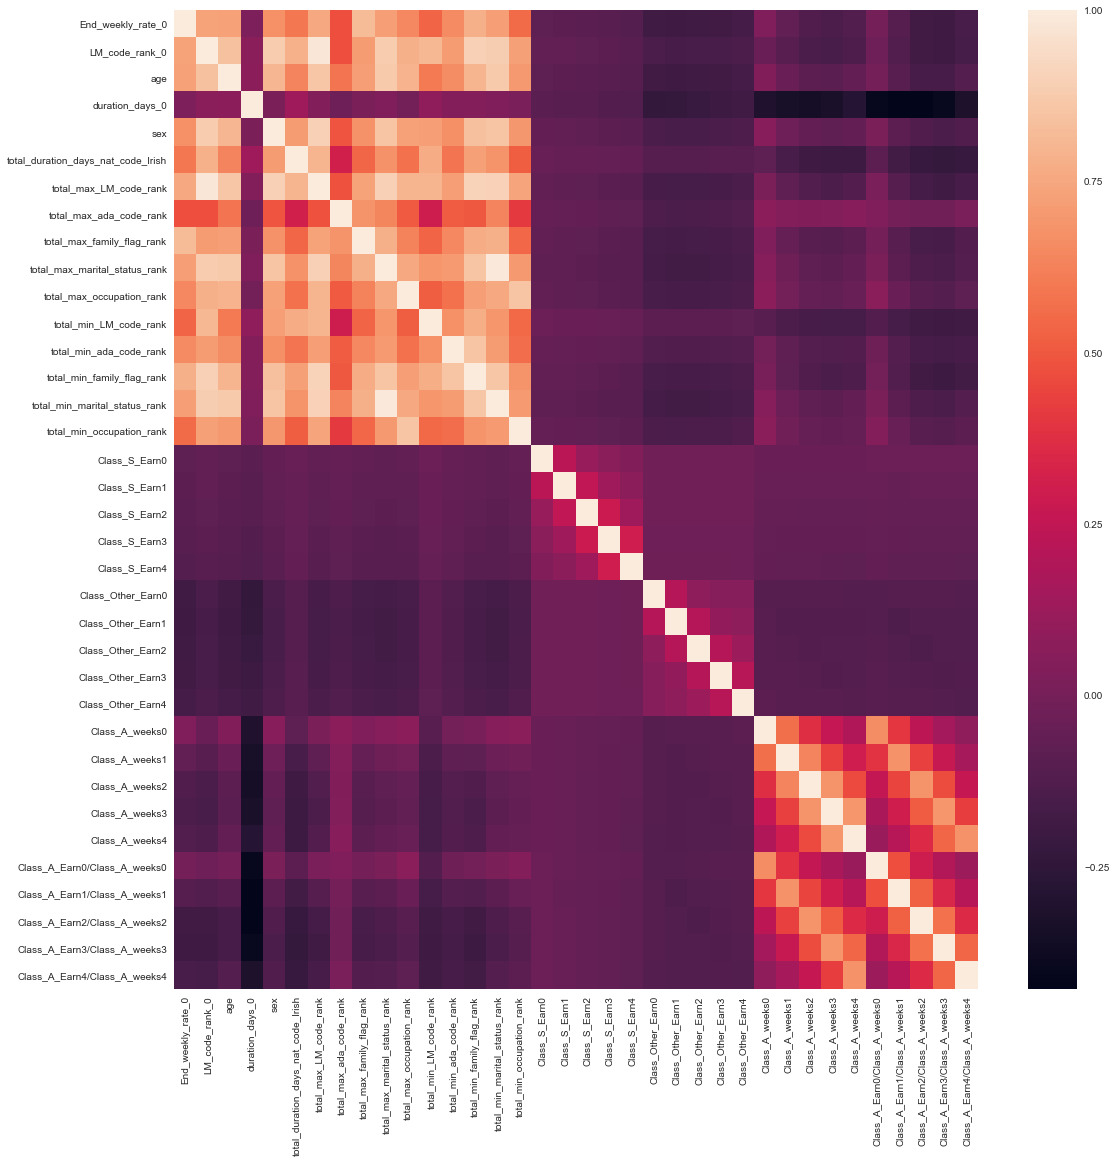

PCA Scatterplot


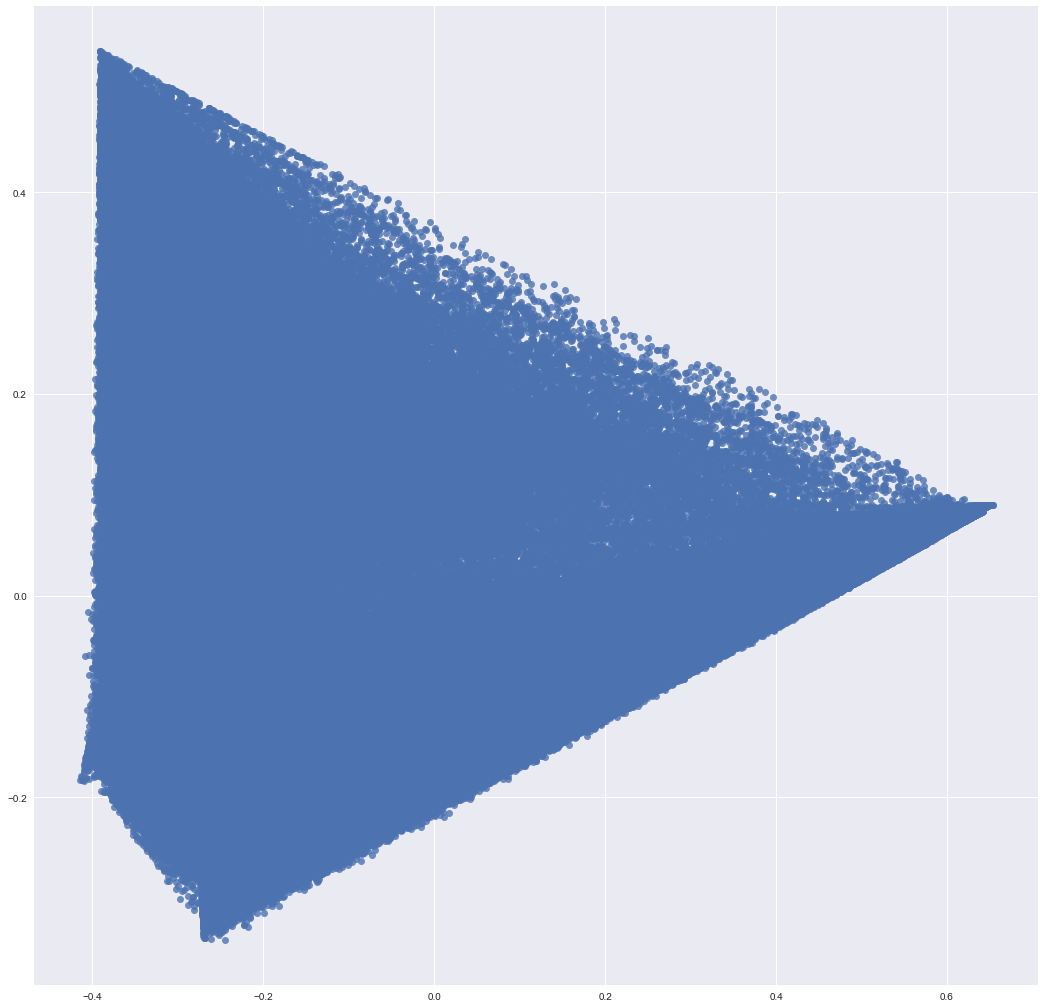

Build Mixture Models and Assign Clusters


C:\Users\MarcoGrimaldi\anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Test Accuracy on associated Predictive Modelling Problem
Accuracy:
0.9945372156173117
Calculate Feature importance for given Cluters (Random Forest)
Done iteration 0
	Procedure time: 00:58:00
Done iteration 1
	Procedure time: 00:58:02
Done iteration 2
	Procedure time: 00:57:45
Total time: 02:53:48


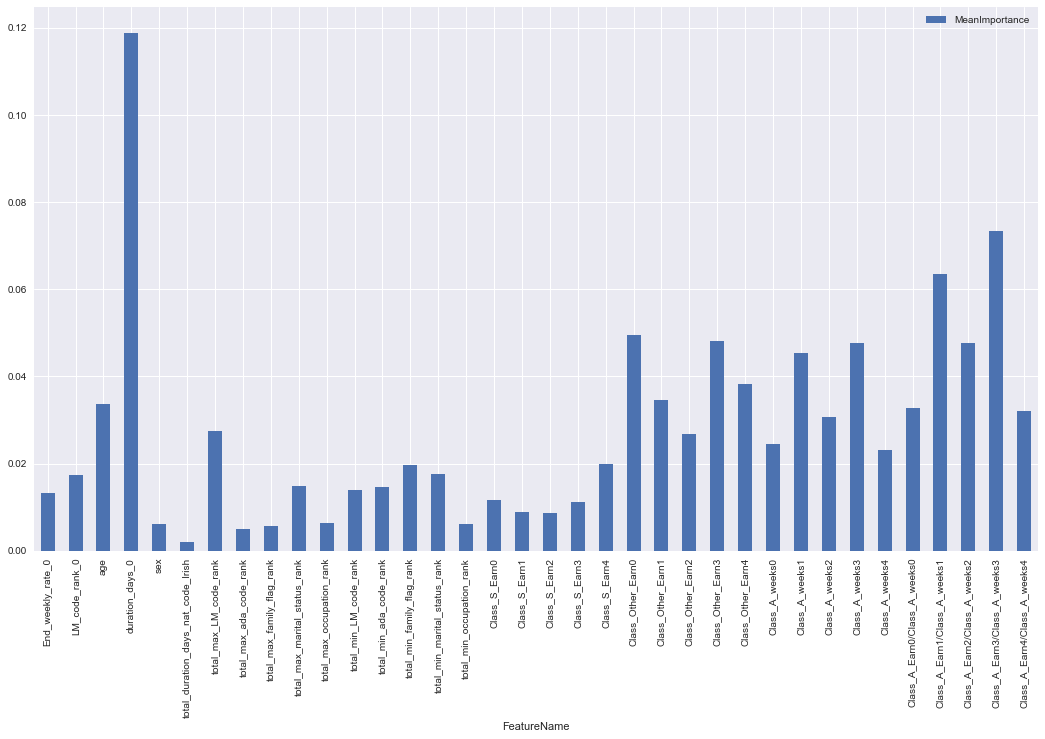


Uploading to SQL cluster table: linkedclaims_casuals_2018m04_v2_flat_multi_with_income_36Vars__7BGM_full_clusters
	Upload time: 00:00:48

Uploading to SQL feature importance table: linkedclaims_casuals_2018m04_v2_flat_multi_with_income_36Vars__7BGM_full_clusters_FeatImportance
	Upload time: 00:00:00

Uploading to SQL cluster means table: linkedclaims_casuals_2018m04_v2_flat_multi_with_income_36Vars__7BGM_full_clusters_means
	Upload time: 00:00:00

Uploading to SQL cluster covars table: linkedclaims_casuals_2018m04_v2_flat_multi_with_income_36Vars__7BGM_full_clusters_covars
	Upload time: 00:00:00

ALL DONE


In [3]:
# Load Data from SQL, select Variables and Fill NA

def read_data_from_sql(sql_table):
    # Connect to SQL
    params = urllib.parse.quote_plus(odbc_connection_string)
    engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
    conn = engine.connect().connection

    @event.listens_for(engine, 'before_cursor_execute')
    def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
        if executemany:
            cursor.fast_executemany = True

    df = pd.read_sql_table(sql_table, engine)
    conn.close()
    return df

def select_variables_fillna(df, do_one_hot_coding = False):
    features = pd.read_csv(varprofile_csvfilename)

    # Select variables based on stats feature selection
    var_sel = features[features.selected==1].Variable.tolist()
    ppsns = df['ppsn']
    df = df[var_sel].copy()

    # # filling NA with 0
    df.fillna(0, inplace=True)

    # One-hot coding on varchar variables
    if do_one_hot_coding:
        varchar = features.loc[((features.selected==1) & (features.Type=='Char')),:].Variable.tolist()
        df = pd.get_dummies(df, columns = varchar )
        
    if do_clip_to_zero:
        df = df.clip(lower=0)
    
    return df, ppsns

print ('Reading data from SQL')
df = read_data_from_sql(sql_table)

print ('Selecting Variables and filling na')
df, ppsns =  select_variables_fillna(df)



# Variables Normalization (Total Day Counts)

def normalize_total_day_counts(df, drop_norm_col = False):
    col_names = df.columns.tolist()
    name_needle = 'total_duration_days_'
    norm_col = 'total_duration_days'

    for col in col_names:
        if name_needle in col:
            df[col] = df[col] / (df[norm_col]+1)
    
    if drop_norm_col == True:
        df.drop(columns=[norm_col], inplace=True)
    return df

if do_normalize_total_day_counts:
    print ('Normalising total_day_counts')
    df = normalize_total_day_counts(df, drop_normalisation_column)

    if (show_plots):
        print ('PCA Scatterplot')
        pca = PCA(n_components=2)
        pca.fit(df)
        X = pca.transform(df)

        sns.regplot(x=X[:,0], y=X[:,1], fit_reg=False)

# Combine Columns
def sum_columns(df, columns_to_sum, drop_original_cols = False):
    for columns in columns_to_sum:
        cols_in_dataset = True
        for col in columns:
            if col not in df.columns.tolist():
                cols_in_dataset = False
        if cols_in_dataset:
            myname = '+'.join(columns)
            df[myname] = df[columns[0]]
            for i in range(1, len(columns)):
                df[myname] = df[myname] + df[columns[i]]
    if drop_original_cols:
        to_drop = []
        for columns in columns_to_sum:
            for col in columns:
                to_drop.append(col)
        df.drop(columns=to_drop, inplace=True)

def divide_columns(df, columns_to_divide, drop_nominator = True, drop_denominator = False):
    for columns in columns_to_divide:
        cols_in_dataset = True
        for col in columns:
            if col not in df.columns.tolist():
                cols_in_dataset = False
        if cols_in_dataset:
            myname = '/'.join(columns)
            df[myname] = df[columns[0]]
            for i in range(1, len(columns)):
                df[myname] = df[myname] / (df[columns[i]] +1)
    
    cols_to_drop = []
    if drop_nominator:
        for cols in columns_to_divide:
            cols_to_drop.append(cols[0])
    if drop_denominator:
        for cols in columns_to_divide:
            cols_to_drop.append(cols[1])
    if len(cols_to_drop) > 0:
        df.drop(columns=cols_to_drop, inplace=True)
        

if do_sum_columns:
    print ('Summing Columns')
    sum_columns(df, columns_to_sum, drop_original_cols)
    
if do_divide_columns:
    print ('Dividing Columns')
    divide_columns(df, columns_to_divide, drop_nominator, drop_denominator)

## Variables Used for Clustering
if (show_plots):
    print ('List of Variables:')
    print (df.columns.tolist())
    print ('Total Number of variables: %d' %(len(df.columns.tolist())))

if (show_plots):
    print ('Correlation Matrix')
    sns.set(rc={'figure.figsize':(18,18)})
    sns.heatmap(df.corr())
    plt.show()

if (show_plots):
    print ('PCA Scatterplot')
    pca = PCA(n_components=2)
    pca.fit(df)
    X = pca.transform(df)
    sns.regplot(x=X[:,0], y=X[:,1], fit_reg=False)
    plt.show()

# Dirichlet Prior
def dirichlet_prior(df, sql_table):
    row_sum = np.sum(df, axis=1).tolist()
    for col in df.columns.tolist():
        df[col] = np.array(df[col].tolist()) / np.array(row_sum)

    col_mean = np.average(df, weights=row_sum, axis = 0)
    
    df = read_data_from_sql(sql_table)
    df, _ = select_variables_fillna(df)

    if do_normalize_total_day_counts:
        df = normalize_total_day_counts(df, drop_normalisation_column)
    if do_sum_columns:
        sum_columns(df, columns_to_sum, drop_original_cols)
    if do_divide_columns:
        divide_columns(df, columns_to_divide, drop_nominator, drop_denominator)
    
    df = df + col_mean
    row_sum = np.sum(df, axis=1).tolist()
    for col in df.columns.tolist():
        df[col] = np.array(df[col].tolist()) / np.array(row_sum)
    
    return df

if do_dirichlet_prior:
    print ('Applying Dirichlet Prior')
    df = dirichlet_prior(df, sql_table)

    if show_plots:
        print ('Correlation Matrix')
        sns.heatmap(df.corr())
        plt.show()

    if show_plots:
        print ('PCA Scatterplot')
        pca = PCA(n_components=2)
        pca.fit(df)
        X = pca.transform(df)
        sns.regplot(x=X[:,0], y=X[:,1], fit_reg=False)
        plt.show()

# Feature Importance

# There are indeed several ways to get feature "importances". As often, there is no strict consensus about what this word means.
# In scikit-learn, we implement the importance as described in [1]. It is sometimes called "gini importance" or 
# "mean decrease impurity" and is defined as the total decrease in node impurity (weighted by the probability of reaching that 
# node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.
# In the literature or in some other packages, you can also find feature importances implemented as the 
# "mean decrease accuracy". Basically, the idea is to measure the decrease in accuracy on OOB data when you randomly permute 
# the values for that feature. If the decrease is low, then the feature is not important, and vice-versa.

# (Note that both algorithms are available in the randomForest R package.)

# [1]: Breiman, Friedman, "Classification and regression trees", 1984.

## Build Mixture Models and Assign Clusters
print ('Build Mixture Models and Assign Clusters')
mm_type = BayesianGaussianMixture
if use_bayesian_mixtures == False:
    mm_type = GaussianMixture

mm_covariance_type = 'full'
if use_full_covariance == False:
    mm_covariance_type = 'diag'

mm = mm_type(n_components=n_clusters, covariance_type=mm_covariance_type)
mm.fit(df)

# mybic = gmm.bic(df)
# myaic = gmm.aic(df)
# print ('BIC Score: %f' %(mybic))
# print ('AIC Score: %f' %(myaic))

clusters = mm.predict(df)

## Test Accuracy on associated Predictive Modelling Problem
print ('Test Accuracy on associated Predictive Modelling Problem')
X_train, X_test, y_train, y_test = train_test_split(df, clusters, test_size=0.33)
n_trees = 1000
clf = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

myaccuracy = accuracy_score(y_test, y_pred)
print ('Accuracy:')
print (myaccuracy)

## Calculate Feature importance for given Cluters (Random Forest)
print('Calculate Feature importance for given Cluters (Random Forest)')
proctime = time.time()
n_trees = 1000
importance = pd.DataFrame()
importance['FeatureName'] = df.columns.tolist()
for i in range(n_iterations):
    looptime = time.time()
    
    X_train, X_test, y_train, y_test = train_test_split(df, clusters, test_size=0.33)
    clf = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1)
    clf.fit(X_train, y_train)
    importance_iter= clf.feature_importances_
    importance['Importance_'+str(i)] = importance_iter
    
    print ('Done iteration %d' %(i))
    elapsed_time = time.time() - looptime
    print ('\tProcedure time: '+ time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

elapsed_time = time.time() - proctime
print ('Total time: '+ time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

mean_importance = pd.DataFrame()
mean_importance['MeanImportance']= importance.mean(axis=1, numeric_only=True)
mean_importance['FeatureName'] = importance['FeatureName']

if show_plots:
    mean_importance.plot.bar(x = 'FeatureName', figsize=(18,10))
    plt.show()

# UPLOAD TO SQL
def upload_data_to_sql(odbc_connection_string, sql_table, data):
    # Connect to SQL
    params = urllib.parse.quote_plus(odbc_connection_string)
    engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
    conn = engine.connect().connection
    cursor = conn.cursor()

    # Drop table if exists
    sql_string_drop = "IF OBJECT_ID('"+ sql_table + "', 'U') IS NOT NULL" +'\n'+ "DROP TABLE " + sql_table
    cursor.execute(sql_string_drop)
    conn.commit()
    conn.close()

    # Connect to SQL
    params = urllib.parse.quote_plus(odbc_connection_string)
    engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
    conn = engine.connect().connection

    # SpeedUp For fast execution of mutiple row 
    @event.listens_for(engine, 'before_cursor_execute')
    def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
        if executemany:
            cursor.fast_executemany = True

    #upload data
    sql_chunksize = 10000
    data.to_sql(sql_table, engine, if_exists='append', index=False, chunksize=sql_chunksize)
    #Close SQL Connection
    conn.close()
    return

# Upload clusters info
data = pd.DataFrame()
data['cluster'] = clusters
data['ppsn'] = ppsns

n_vars = len(df.columns.tolist())
mm_type_name = 'BGM'
if use_bayesian_mixtures == False:
    mm_type_name = 'GMM'

sql_table_cluster_out = sql_table + "_"+str(n_vars)+"Vars_"+ "_"+str(n_clusters)+mm_type_name+"_"+mm_covariance_type+"_clusters"

mytime = time.time()
print('\nUploading to SQL cluster table: %s' %(sql_table_cluster_out))
upload_data_to_sql(odbc_connection_string, sql_table_cluster_out, data)
    
elapsed_time = time.time() - mytime
print ('\tUpload time: '+ time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

# Upload feat importance
sql_table_feature_importance_out = sql_table + "_"+str(n_vars)+"Vars_"+ "_"+str(n_clusters)+mm_type_name+"_"+mm_covariance_type+"_clusters_FeatImportance"

mytime = time.time()
print('\nUploading to SQL feature importance table: %s' %(sql_table_feature_importance_out))
upload_data_to_sql(odbc_connection_string, sql_table_feature_importance_out, mean_importance)
    
elapsed_time = time.time() - mytime
print ('\tUpload time: '+ time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


## UPLOAD GMM CENTERS AND STDDEV
columns_name = df.columns.tolist()
mm_means = pd.DataFrame(mm.means_, columns=columns_name)
mm_means['cluster'] = mm_means.index


sql_table_cluster_means_out = sql_table + "_"+str(n_vars)+"Vars_"+ "_"+str(n_clusters)+mm_type_name+"_"+mm_covariance_type+"_clusters_means"

mytime = time.time()
print('\nUploading to SQL cluster means table: %s' %(sql_table_cluster_means_out))
upload_data_to_sql(odbc_connection_string, sql_table_cluster_means_out, mm_means)
    
elapsed_time = time.time() - mytime
print ('\tUpload time: '+ time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


mm_covars = pd.DataFrame()
if mm_covariance_type == 'diag':
    columns_name = df.columns.tolist()
    mm_covars = pd.DataFrame(mm.covariances_, columns=columns_name)
    mm_covars['cluster'] = mm_means.index
elif mm_covariance_type == 'full':
    covars = mm.covariances_
    columns_name = df.columns.tolist()
    for i in range(len(covars)):
        cluster = i*np.ones(len(covars[i]))
        cluster_covariance = np.matrix(covars[i])

        mydf = pd.DataFrame()
        mydf ['cluster'] = cluster
        for cn in range(len(columns_name)):
            mydf [columns_name[cn]] = cluster_covariance[:,cn]
        mm_covars = mm_covars.append(mydf, ignore_index=True)


sql_table_cluster_covars_out = sql_table + "_"+str(n_vars)+"Vars_" + "_"+str(n_clusters)+mm_type_name+"_"+mm_covariance_type+"_clusters_covars"

mytime = time.time()
print('\nUploading to SQL cluster covars table: %s' %(sql_table_cluster_covars_out))
upload_data_to_sql(odbc_connection_string, sql_table_cluster_covars_out, mm_covars)

elapsed_time = time.time() - mytime
print ('\tUpload time: '+ time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


print ('\nALL DONE')